# Dataset Generation
Generates 50K samples of 2D random noise form different distributions:

- Gaussian noise
- Uniform noise
- Salt and Pepper noise
- Poisson noise
- Brownian noise

In [16]:
try:
    import jax.numpy as jnp
    from jax import random
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    import os
except ModuleNotFoundError:
    %pip install jax matplotlib tqdm --quiet

In [17]:
def salt_and_pepper(key, size, prob, n_images):
        noise_images = []
        
        for _ in range(n_images):
                key, subkey = random.split(key)

                output = jnp.zeros(size)
                pepper = random.uniform(subkey, size) < prob / 2
                salt = random.uniform(subkey, size) < prob / 2
                output = output.at[pepper].set(-1)
                output = output.at[salt].set(1)
                
                noise_images.append(output)

        return jnp.array(noise_images)

In [18]:
def brownian_noise(key, size, n_images):
        noise_images = []
        
        for _ in range(n_images):
                key, subkey = random.split(key)

                noise_images.append(jnp.cumsum(random.normal(subkey, size), axis=0))

        return jnp.array(noise_images)

In [19]:
def perlin(size):
    pass # TODO

In [20]:
def generate_noise_samples(key, image_size, n_samples):
    samples = {}

    key, subkey = random.split(key)
    samples['gaussian_noise'] = random.normal(subkey, shape=(n_samples, *image_size))

    key, subkey = random.split(key)
    samples['uniform_noise'] = random.uniform(subkey, shape=(n_samples, *image_size))

    key, subkey = random.split(key)
    samples['salt_and_pepper_noise'] = salt_and_pepper(subkey, image_size, 0.05, n_samples)

    key, subkey = random.split(key)
    samples['poisson_noise'] = random.poisson(subkey, shape=(n_samples, *image_size), lam=5.0)

    key, subkey = random.split(key)
    samples['brownian_noise'] = brownian_noise(subkey, image_size, n_samples)

    return samples


In [21]:
def save_batch(path, batch, batch_no, batch_size):

    os.makedirs(path, exist_ok=True)

    for noise_type, noises in batch.items():
        for i, noise in enumerate(noises):
            image_id = batch_no * batch_size + i
            plt.imsave(f'{path}/{noise_type}_{image_id:04d}.png', noise, format='png', cmap='gray')

In [22]:
def generate_noise_dataset(key, path, image_size, n_samples, batch_size=64):
    total_batches = (n_samples + batch_size - 1) // batch_size

    for i in tqdm(range(total_batches)):
        key, noise_key = random.split(key)

        samples_in_batch = min(batch_size, n_samples - i * batch_size)

        batch = generate_noise_samples(noise_key, image_size, samples_in_batch)
        save_batch(path, batch, i, batch_size)

In [23]:
dataset_key, test_key = random.split(random.PRNGKey(0))
image_size = (64, 64)
n_samples = int(1e4)

generate_noise_dataset(dataset_key, '../noise_dataset', image_size, n_samples)

100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


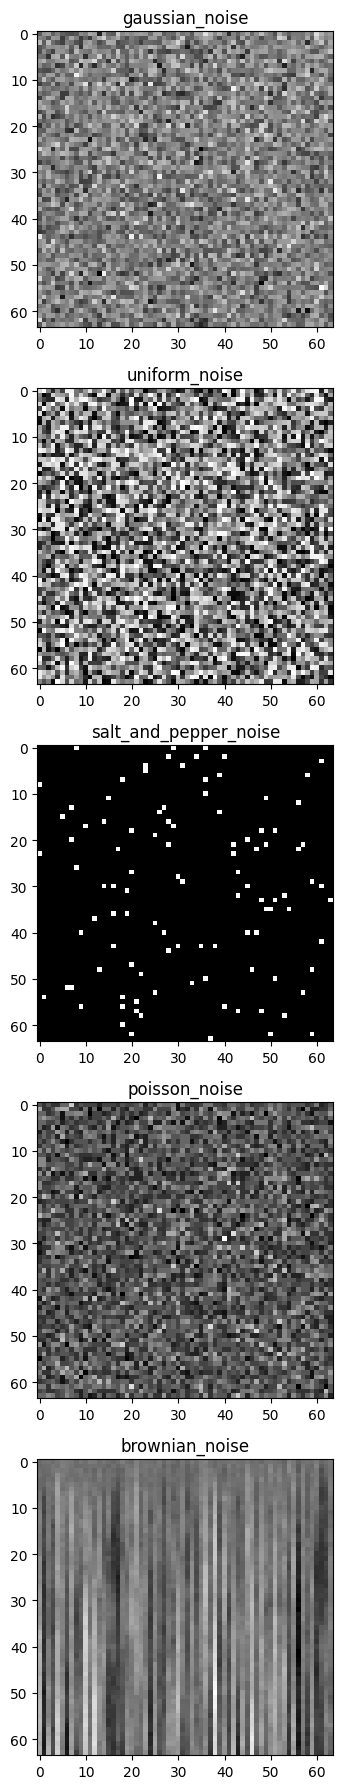

In [24]:
display_samples = generate_noise_samples(test_key, image_size, 1)

fig, axes = plt.subplots(5, 1, figsize=(12, 18))
for i, (noise_type, noise_data) in enumerate(display_samples.items()):
    axes[i].imshow(noise_data[0], cmap='gray')
    axes[i].set_title(noise_type)
plt.tight_layout()
plt.show()